# Imports and Data Loading

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

leak_data_raw =  pd.read_csv("Gasleak Data Sets/sensor_readings.csv")
leak_data_raw.columns = ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

# weather_df = pd.read_csv("Gasleak Data Sets/weather_data.csv")
# columns_to_average = ['Barometric_Pressure', 'Humidity', 'Temperature', 'Wind_Direction', 'Wind_Speed']
# for col in columns_to_average:
#     weather_df[col] = weather_df.groupby('timestamp')[col].transform('mean')
# weather_df = weather_df.drop_duplicates()
# weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp']).astype(int) // 10**9
# weather_df = weather_df.rename(columns={'timestamp': 'tTime'})

# leak_rate_df = pd.read_csv("Gasleak Data Sets/leak_locations_and_rate.csv")
# leak_rate_df =  leak_rate_df[['LeakRate', 'tStart', 'tEnd', 'Duration']]
# leak_rate_df['LeakRate'] = leak_rate_df.groupby('tStart')['LeakRate'].transform('mean')
# leak_rate_df = leak_rate_df.drop_duplicates()


# Data Prep

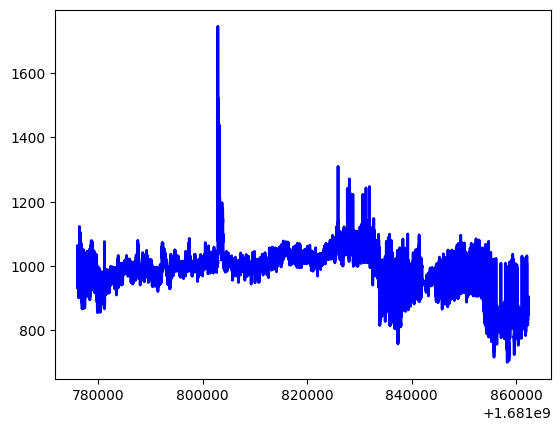

In [64]:
df = leak_data_raw.drop(['temp'], axis=1)
plt.plot(df['Time'], df['Sensor 1'], linewidth=2, linestyle="-", c="b") 


Data is very noisy, must filter

In [65]:
leak_data = df.copy()
leak_data['Total'] = leak_data.iloc[:,1:].sum(axis=1)
leak_data['Time'] -= 1681776002
leak_data

,Time,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,...,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Sensor 22,Sensor 23,Sensor 24,Total
0,0,1030.0,1049.0,1166.0,964.0,1023.0,1090.5,1039.5,1153.0,1082.0,...,735.0,1088.0,991.5,931.0,1040.0,1040.0,1111.0,1080.0,1089.0,25204.5
1,1,1033.0,1051.0,1163.0,974.0,993.0,1095.0,1044.0,1152.0,1085.0,...,765.0,1090.0,984.0,928.5,1043.0,1052.0,1105.5,1075.0,1095.0,25186.0
2,2,1022.0,1051.0,1160.0,975.5,974.0,1081.0,1049.0,1133.0,1088.0,...,762.0,1095.0,993.0,926.0,1039.0,1033.0,1100.0,1021.0,1093.0,25082.0
3,3,1034.0,1050.0,1165.0,977.0,988.0,1084.0,1019.0,1128.0,1091.0,...,762.0,1100.0,999.0,929.0,1047.5,1014.0,1107.0,1059.5,1110.0,25172.5
4,4,1037.5,1049.0,1155.0,977.0,971.0,1084.0,1027.0,1144.0,1090.5,...,763.0,1100.0,1004.5,944.0,1056.0,1019.0,1098.0,1098.0,1107.5,25176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83408,86393,853.0,901.0,990.0,813.0,791.0,911.0,887.0,943.0,968.0,...,661.0,1037.0,900.5,795.0,1007.0,955.0,1020.0,949.0,987.0,22096.0
83409,86394,852.5,899.0,1007.0,801.0,788.5,900.0,890.0,931.0,984.0,...,644.0,1056.0,901.0,799.5,1009.0,954.0,1018.0,955.0,986.0,22024.5
83410,86395,852.0,901.0,1011.0,811.0,786.0,909.0,899.0,945.0,967.0,...,643.0,1059.0,908.0,804.0,1016.0,961.0,1017.0,938.0,982.0,22084.0
83411,86396,859.0,912.0,1010.0,811.0,764.0,909.0,892.0,959.0,969.0,...,609.0,1071.0,897.0,802.0,1019.0,963.0,1026.0,948.0,990.0,22018.5


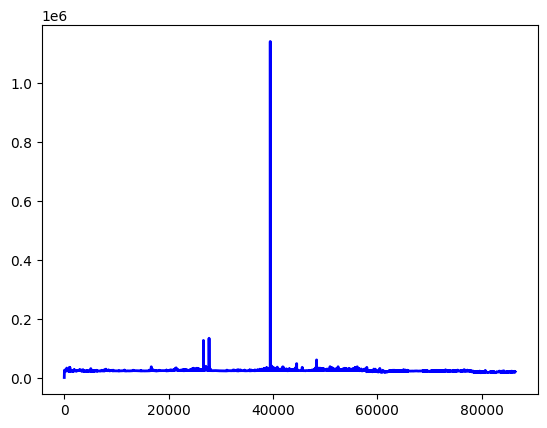

In [66]:
leak_data['Total'] = pd.DataFrame(lfilter([1.0 / 10] * 10, 1, leak_data['Total']))
plt.plot(leak_data['Time'], leak_data['Total'], linewidth=2, linestyle="-", c="b")  # smooth by filter

lot less noise

# Train Model

In [67]:
# Imports
import torch

import lightning as L
from torch.utils.data import TensorDataset, DataLoader
import model as m


model = m.LightningLSTM()

In [76]:
normalized_sensor_total = (leak_data['Total'] - leak_data['Total'].min()) / (leak_data['Total'].max() - leak_data['Total'].min())
normalized_sensor_total = normalized_sensor_total.astype(dtype='float32')

normalized_sensor_total

0        0.000000
1        0.002214
2        0.004420
3        0.006633
4        0.008847
           ...   
83408    0.017248
83409    0.017231
83410    0.017213
83411    0.017197
83412    0.017176
Name: Total, Length: 83413, dtype: float32

In [77]:
window_size = 60

# Create a list of input sequences
inputs = [normalized_sensor_total.iloc[i:i+window_size].values for i in range(len(normalized_sensor_total) - window_size)]

# Create a list of corresponding labels
labels = normalized_sensor_total.iloc[window_size:].values

inputs = torch.tensor(np.array(inputs), dtype=torch.float32) # convert to numpy
labels = torch.tensor(np.array(labels), dtype=torch.float32)

dataset =  TensorDataset(inputs, labels) 
dataloader = DataLoader(dataset)


In [86]:
trainer = L.Trainer(max_epochs=1)
trainer.fit(model,train_dataloaders=dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 16    
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 83353/83353 [08:36<00:00, 161.23it/s, v_num=34]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 83353/83353 [08:36<00:00, 161.23it/s, v_num=34]


In [50]:
path_to_best_checkpoint = trainer.checkpoint_callback.best_model_path
trainer = L.Trainer(max_epochs=10)
trainer.fit(model,train_dataloaders=dataloader, ckpt_path=path_to_best_checkpoint)

# Test Data

In [79]:
test_data_raw = pd.read_csv("Gasleak Data Sets/validation_files/sensor_readings.csv")
test_data_raw.columns =  ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]
test_leak_data = test_data_raw.copy()
test_leak_data = test_leak_data.drop(['temp'], axis=1)
test_leak_data['Time'] -= 1681776002
test_leak_data['Total'] = test_leak_data.iloc[:,1:].sum(axis=1)
test_leak_data['Total'] = pd.DataFrame(lfilter([1.0 / 10] * 10, 1, test_leak_data['Total']))


normalized_test_sensor_total = (test_leak_data['Total'] - leak_data['Total'].min()) / (leak_data['Total'].max() - leak_data['Total'].min())
normalized_test_sensor_total = normalized_test_sensor_total.astype(dtype='float32')

normalized_test_sensor_total

0       -0.000434
1        0.001491
2        0.003422
3        0.005343
4        0.007275
           ...   
83783    0.018419
83784    0.018399
83785    0.018393
83786    0.018367
83787    0.018351
Name: Total, Length: 83788, dtype: float32

In [92]:
# Set the window size
window_size = 60

# Create a list of input sequences
inputs = [normalized_test_sensor_total.iloc[i:i+window_size].values for i in range(len(normalized_test_sensor_total) - window_size)]

# Create a list of corresponding labels
labels = normalized_test_sensor_total.iloc[window_size:,].values

# # Convert the lists to pandas objects
prediction_df = pd.concat([pd.DataFrame(inputs), pd.Series(labels)], axis=1)

test_inputs = torch.tensor(np.array(inputs), dtype=torch.float32) # convert to numpy
test_labels = torch.tensor(np.array(labels), dtype=torch.float32)

In [93]:
labels

array([0.01730934, 0.01731019, 0.01730983, ..., 0.01839285, 0.01836726,
       0.01835073], dtype=float32)

In [87]:
ins = []
lab = []
prediction_normalized = []
for i in range(0,len(test_inputs),1000):
    prediction_normalized.append(model(test_inputs[i]).detach())
    ins.append(inputs[i])
    lab.append(labels[i])
prediction_df =  pd.DataFrame(prediction_normalized,columns=['prediction_normalized'])
prediction_df['prediction'] = prediction_df['prediction_normalized'] * (leak_data['Total'].max() - leak_data['Total'].min()) + leak_data['Total'].min()
prediction_df['labels_normalized'] = pd.Series(lab)
prediction_df = prediction_df.astype('float32')
prediction_df['labels'] = prediction_df['labels_normalized'] * (leak_data['Total'].max() - leak_data['Total'].min()) + leak_data['Total'].min()

# predictions = prediction_df.iloc[57:, :-1].apply(lambda x: model(torch.tensor(x, dtype=torch.float32)), axis=1)

prediction_df

,prediction_normalized,prediction,labels_normalized,labels
0,0.017146,22021.058594,0.017309,22206.943359
1,0.017137,22010.726562,0.016908,21750.699219
2,0.017159,22036.011719,0.017874,22849.500000
3,0.017153,22028.917969,0.017602,22539.400391
4,0.017138,22012.126953,0.016938,21784.550781
...,...,...,...,...
79,0.017208,22091.296875,0.020117,25400.699219
80,0.017214,22098.044922,0.020132,25417.373047
81,0.017239,22127.003906,0.020021,25290.750000
82,0.017188,22068.951172,0.019102,24245.248047


In [88]:
rmse = np.sqrt( np.mean(prediction_df['prediction'] - prediction_df['labels'])**2)
rmse #OOF

2926.77783203125

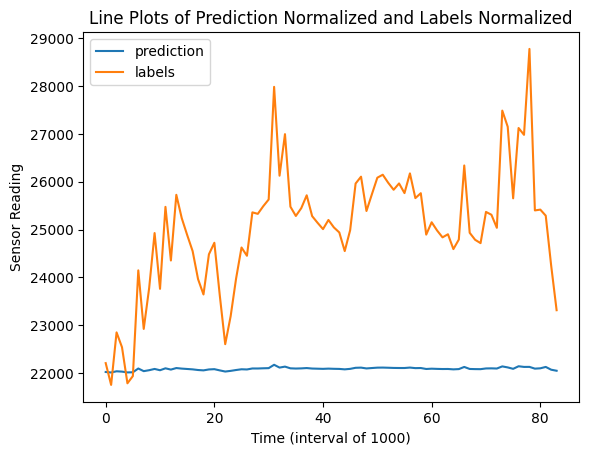

In [89]:
def graph():
    plt.plot(prediction_df['prediction'], label='prediction')
    plt.plot(prediction_df['labels'], label='labels')
    plt.xlabel('Time (interval of 1000)')
    plt.ylabel('Sensor Reading')
    plt.title('Line Plots of Prediction Normalized and Labels Normalized')
    plt.legend()
    plt.show()
graph()